In [1]:
using ITensors, ITensorMPS

let
    # Create spin-1/2 indices
    global L = 30
    global sites = siteinds("S=1/2", L)

    # Create the Hamiltonian of the Ising chain at its self-dual critical point
    # from the O'Brien and Fendley paper.
    os_I = OpSum()
    for j in 1:(L - 1)
        os_I -= "X", j 
        os_I -= "Z", j, "Z", j + 1
    end
    # Boundary conditions
    os_I -= "X", L # j = L
    os_I -= "Z", L, "Z", 1

    H_I = MPO(os_I, sites)

    # Create the Hamiltonian of the three-spin interaction from the O'Brien and Fendley paper.
    os_3 = OpSum()
    for j in 1:(L - 2)
        os_3 += "X", j, "Z", j + 1, "Z", j + 2
        os_3 += "Z", j, "Z", j + 1, "X", j + 2
    end
    os_3 += "X", L - 1, "Z", L, "Z", 1
    os_3 += "X", L, "Z", 1, "Z", 2
    os_3 += "Z", L - 1, "Z", L, "X", 1
    os_3 += "Z", L, "Z", 1, "X", 2
    
    H_3 = MPO(os_3, sites)

    # Ground state coupling coefficients
    # lambda_I = 1
    # lambda_3 = 1

    # Tri-Critical Ising coupling coefficients
    lambda_I = 0.7597
    lambda_3 = 0.6503
    
    global H = 2 * lambda_I * H_I + lambda_3 * H_3

    # Create an initial random matrix product state
    psi0 = random_mps(sites)

    # Sweeps, maximum dimesnions, cutoff value, and observer
    nsweeps = 20
    maxdim = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]
    cutoff = 1.0e-7
    observer = DMRGObserver(; energy_tol=1.0e-7, minsweeps=4)

    global energy1, psi1 = dmrg(H, psi0; nsweeps, maxdim, cutoff, observer=observer)
    global energy2, psi2 = dmrg(H, [psi1], psi0; nsweeps, maxdim, cutoff, weight = 100, observer=observer)
    global energy3, psi3 = dmrg(H, [psi1, psi2], psi0; nsweeps, maxdim, cutoff, weight = 100, observer=observer)
    global energy4, psi4 = dmrg(H, [psi1, psi2, psi3], psi0; nsweeps, maxdim, cutoff, weight = 100, observer=observer)

    nothing
end

After sweep 1 energy=-45.62480390716301  maxlinkdim=4 maxerr=1.54E-16 time=12.603
After sweep 2 energy=-46.045205294147245  maxlinkdim=12 maxerr=9.75E-08 time=0.078
After sweep 3 energy=-46.054065689810855  maxlinkdim=14 maxerr=9.85E-08 time=0.092
After sweep 4 energy=-46.10800923196435  maxlinkdim=23 maxerr=9.96E-08 time=0.523
After sweep 5 energy=-46.142294435745114  maxlinkdim=44 maxerr=1.00E-07 time=0.338
After sweep 6 energy=-46.151558826712495  maxlinkdim=52 maxerr=9.99E-08 time=0.572
After sweep 7 energy=-46.15241991796128  maxlinkdim=55 maxerr=9.96E-08 time=0.733
After sweep 8 energy=-46.152450835343494  maxlinkdim=50 maxerr=9.94E-08 time=0.664
After sweep 9 energy=-46.15245383835799  maxlinkdim=50 maxerr=9.97E-08 time=0.648
After sweep 10 energy=-46.15245514833077  maxlinkdim=50 maxerr=9.99E-08 time=0.607
After sweep 11 energy=-46.15245508301791  maxlinkdim=49 maxerr=9.95E-08 time=0.563
Energy difference less than 1.0e-7, stopping DMRG
After sweep 1 energy=-44.50101478472813  

Connected correlation X for state 1 and state 4 = 0.14692199282889828


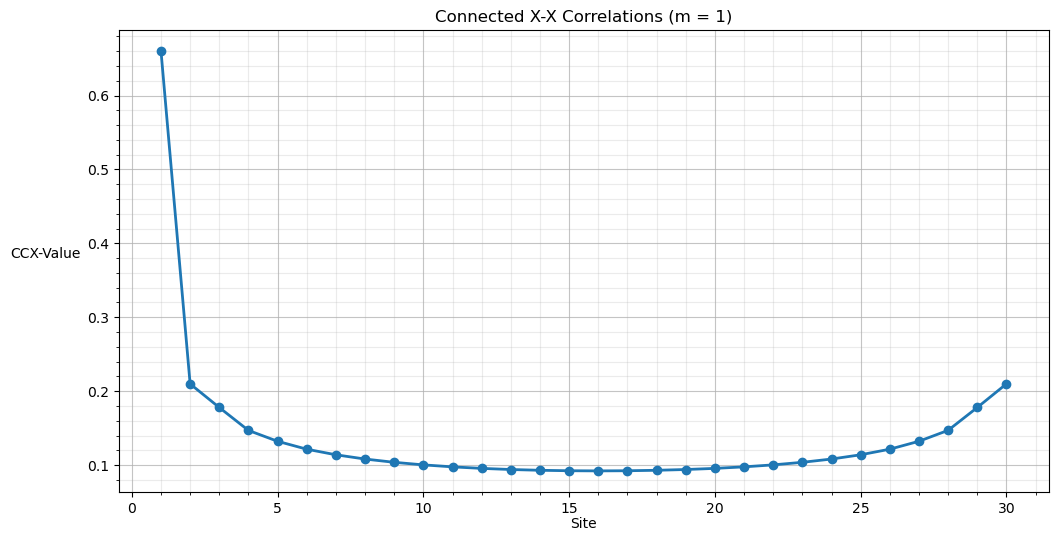

Python: None

In [2]:
using PythonPlot

# Creating function to compute the connected correlation for X 
function connected_correlation_X(psi, sites, m, n)

# Create MPO for Xm 
os_Xm = OpSum() 
os_Xm += "X", m 
XmMPO = MPO(os_Xm, sites)

# Create MPO for Xn 
os_Xn = OpSum() 
os_Xn += "X", n 
XnMPO = MPO(os_Xn, sites)

# Create MPO for XmXn
os_Xmn = OpSum() 
os_Xmn += "X", m, "X", n 
XmXnMPO = MPO(os_Xmn, sites) 

# Expectation values 
Xm = inner(psi', XmMPO, psi) # <psi|Xm|psi> 
Xn = inner(psi', XnMPO, psi) # <psi|Xn|psi> 
XmXn = inner(psi', XmXnMPO, psi) # <psi|XmXn|psi>

return XmXn - Xm * Xn # <XmXn> - <Xm><Xn> 
end 

global m = 1 
global n = 4

# Value of Connected Correlation for chosen sites
CCX = connected_correlation_X(psi1, sites, m, n) 
#CCZ = connected_correlation_Z(psi1, sites, m, n) 

println("Connected correlation X for state $m and state $n = $CCX")
#println("Connected correlation Z for state $m and state $n = $CCZ")
 
# Independent Variable 
x = collect(1:L)

y_X = [connected_correlation_X(psi1, sites, m, n) for n in 1:L] 
figure(figsize=(12, 6)) 
plot(x, y_X, marker="o", linestyle="-", linewidth=2)

xlabel("Site", labelpad=1) 
ylabel("CCX-Value", rotation=0, labelpad=30) 
title("Connected X-X Correlations (m = $m)") 
grid(true, which="major", alpha=0.75)
grid(true, which="minor", alpha=0.25) 
minorticks_on()